In [ ]:
# !pip install rustworkx

In [2]:
import pickle
import os
import numpy as np
import rustworkx as rx
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, diags
import torch
from transformers import AutoImageProcessor, SuperPointForKeypointDetection
import pandas as pd

In [15]:
device = torch.device('cuda' if not torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
class VocabularyTree:
    def __init__(self, num_branches: int, depth: int, image_descriptor_function, clustering_algorithm=None, **kwargs):
        """
        Initializes the Vocabulary Tree.

        Args:
            num_branches: Number of branches at each node.
            depth: Depth of the tree.
            image_descriptor: Function to extract features from images.
            clustering_algorithm: Clustering algorithm to use.
            clustering_params: Parameters for the clustering algorithm.
        """
        self.num_branches = num_branches
        self.depth = depth
        self.image_descriptor = image_descriptor_function
        self.tree = rx.PyDiGraph()  # Directed graph for the vocabulary tree

        if clustering_algorithm is None:
            self.clustering_algorithm = KMeans
        else:
            self.clustering_algorithm = clustering_algorithm
        self.clustering_params = kwargs

        self.image_idx_image_mapping = {}
        self.weights = None
        self.bof = None

    def extract_image_features(self, imagepaths):
        """
        Extracts features for a given array of images.

        Args:
            imagepaths: Array of image paths
        Returns:
            Array of feature descriptors for the images.
        """

        image_descriptors = []
        for imagepath in imagepaths:
            image = cv2.imread(imagepath)
            image_descriptors.append(self.image_descriptor(image))
        return image_descriptors
    

    def create_tree(self, feature_descriptions, current_node=0, node_value=None, current_depth=0):
        """
        Recursively builds the vocabulary tree.

        Args:
            feature_descriptions: Array of feature descriptions.
            current_node: Current node in the tree.
            node_value: Value of the current node (e.g., cluster centroid).
            current_depth: Current depth in the tree.
        """

        if current_node == 0: # If the current node is the root, add root to tree.
            self.tree.add_node(None)
            node_value = np.mean(feature_descriptions, axis=0)

        self.tree[current_node] = {'node_value': node_value, 'inverted_index': {}}


        # Stop if the max depth is reached or no more features to process
        if current_depth >= self.depth or len(feature_descriptions) < self.num_branches:
            return

        unique_descriptors = np.unique(feature_descriptions, axis=0) # Avoid creating clusters with no elements
        if len(unique_descriptors) < self.num_branches:
            return
        
        clustering = self.clustering_algorithm(n_clusters=self.num_branches, random_state=42, **self.clustering_params)
        clustering.fit(feature_descriptions)

        for branch_id in range(self.num_branches):
            child_node = self.tree.add_node(None)
            self.tree.add_edge(current_node, child_node, branch_id)

            cluster_features = feature_descriptions[clustering.labels_ == branch_id]
            cluster_centroid = clustering.cluster_centers_[branch_id]

            self.create_tree(cluster_features, child_node, cluster_centroid, current_depth + 1)


    def build_inverted_index(self, feature_dict):
        """
        Builds the inverted index for the vocabulary tree.

        Args:
            feature_dict: Dictionary mapping image IDs to feature descriptors.
        """

        for image_id, feature_descriptor in feature_dict.items():
            for feature in feature_descriptor:
                current_node = 0

                while self.tree.out_degree(current_node) > 0:
                    children = list(self.tree.successor_indices(current_node))
                    distances = [np.linalg.norm(feature - self.tree[node]['node_value']) for node in children]
                    closest_child = children[np.argmin(distances)]

                    current_node = closest_child

                if image_id in self.tree[current_node]["inverted_index"]:
                    self.tree[current_node]["inverted_index"][image_id] += 1
                else:
                    self.tree[current_node]["inverted_index"][image_id] = 1

    def get_inverted_index(self, node):
        """
        Recursively traverses the tree and returns the inverted index of the child node.

        Args:
            node: Current node in the tree.

        Returns:
            Inverted index of the child node.
        """
        if self.tree.out_degree(node) == 0:

            return self.tree[node]["inverted_index"]
        else:
            inverted_idx = {}
            children = list(self.tree.successor_indices(node))
            for child in children:
                child_inverted_idx = self.get_inverted_index(child)
                for image_id, count in child_inverted_idx.items():
                    if image_id in inverted_idx:
                        inverted_idx[image_id] += count
                    else:
                        inverted_idx[image_id] = count
            return inverted_idx


    def compute_bof(self, num_images):
        """
        Computes the sparse 2D bag of features vector for the vocabulary tree.
        Args:
            num_images: Number of images in the training dataset
        """
        num_nodes = len(self.tree)
        self.weights = np.zeros(num_nodes)

        self.bof = lil_matrix((num_images, num_nodes))
        
        for node in self.tree.node_indexes():
            inverted_idx = self.get_inverted_index(node)
            self.weights[node] = np.log(num_images / len(inverted_idx))

            for image_id, count in inverted_idx.items():
                self.bof[(image_id, node)] = self.weights[node] * count
        

        self.bof = csr_matrix(self.bof)

        row_sums = self.bof.sum(axis=1)
        row_sums_reciprocal = 1.0 / row_sums
        diagonal_matrix = diags(row_sums_reciprocal.A1)
        normalized_matrix = diagonal_matrix.dot(self.bof)
        self.bof = normalized_matrix

    def fit(self, images):
        """
        Fits the vocabulary tree to the training dataset.

        Args:
            images: Array of image paths.
        """

        image_features = self.extract_image_features(images)

        cnt = 0
        non_null_features = []
        image_features_flattened = []
        idx_mapping = {}

        for i in range(len(image_features)):
            if image_features[i] is not None:
                non_null_features.append(image_features[i])
                idx_mapping[cnt] = images[i]
                cnt += 1
                image_features_flattened.extend(image_features[i])
        image_features = np.array(image_features_flattened)

        image_ids = np.arange(len(non_null_features))
        self.image_idx_image_mapping = idx_mapping

        feature_dict = {image_id: features for image_id, features in zip(image_ids, non_null_features)}

        self.create_tree(image_features)
        self.build_inverted_index(feature_dict)
        self.compute_bof(len(non_null_features))


    def get_query_bof(self, feature_descriptors):
        """
        Computes the bag of features for the query image.
        Args:
            feature_descriptors: Array of feature descriptors for the query image.
        Returns:
            Bag of features for the query image.
        """
        bof = np.zeros(len(self.tree))

        for feature in feature_descriptors:
            current_node = 0
            
            bof[current_node] += 1*self.weights[current_node]

            while self.tree.out_degree(current_node) > 0:
                children = list(self.tree.successor_indices(current_node))
                distances = [np.linalg.norm(feature - self.tree[node]['node_value']) for node in children]
                closest_child = children[np.argmin(distances)]

                current_node = closest_child

                bof[current_node] += 1*self.weights[current_node]
        
        return bof

    def query(self, image):
        """
        Queries the vocabulary tree for similar images.
        Args:
            image: Query image.
        Returns:
            Similar image paths and their scores.
        """
        image_features = self.image_descriptor(image)

        qbof = self.get_query_bof(image_features)
        qbof /= np.sum(qbof)

        non_zero_q_nodes = np.nonzero(qbof)[0]

        scores = {}

        for image_id in range(self.bof.shape[0]):
            bof = self.bof.getrow(image_id).toarray()[0]
            
            score = 2
            
            non_zero_bof_nodes = np.nonzero(bof)[0]
            intersection = np.intersect1d(non_zero_q_nodes, non_zero_bof_nodes)

            for i in intersection:
                score += np.abs(qbof[i] - bof[i]) - np.abs(qbof[i]) - np.abs(bof[i])

            scores[image_id] = score

        scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
        images = {k: self.image_idx_image_mapping[k] for k in scores.keys()}
        return scores, images


In [18]:
superpoint_processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
superpoint_model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")
superpoint_model = superpoint_model.to(device)

def superpoint_features(image):

    superpoint_inputs = superpoint_processor(image, return_tensors="pt")

    superpoint_inputs = {k: v.to(device) for k, v in superpoint_inputs.items()}

    superpoint_outputs = superpoint_model(**superpoint_inputs)

    descriptors = superpoint_outputs['descriptors'][0].detach().cpu().numpy()
    return descriptors

In [6]:
training_df = pd.read_csv(os.getcwd() + '\\training_df.csv')
test_df = pd.read_csv(os.getcwd() + '\\test_df.csv')

In [7]:
# tree_superpoint_16_5 = VocabularyTree(num_branches=16, depth=5, image_descriptor_function=superpoint_features)
# tree_superpoint_16_5.fit(training_df['image_path'])

# Importing above trained model
with open(os.getcwd() + '\\trees\\tree_superpoint_16_5.pkl', 'rb') as f:
    tree = pickle.load(f)
f.close()



In [8]:
def read_and_plot_img(img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.title("Query Image")
    plt.show()


def plot_top_k_images(scores, images, k):
    """
    Plots the top k images with their scores as titles.

    Args:
        scores: A dictionary with image IDs as keys and scores as values.
        images: A dictionary with image IDs as keys and images (numpy arrays) as values.
        k: The number of top images to plot.
    """

    top_k_ids = sorted(scores, key=scores.get, reverse=False)[:k]
    top_k_scores = [scores[image_id] for image_id in top_k_ids]
    top_k_images = [images[image_id] for image_id in top_k_ids]

    n_cols = min(3, k)
    n_rows = (k + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

    axes = axes.ravel() if k > 1 else [axes]

    for i in range(k):
        img = top_k_images[i]
        if isinstance(img, str):
            img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"Score: {top_k_scores[i]:.2f}", fontsize=10)
        axes[i].axis("off")

    for j in range(k, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.title("Top 5 Retrieved Images with their Scores (Lower is Better)")
    plt.show()


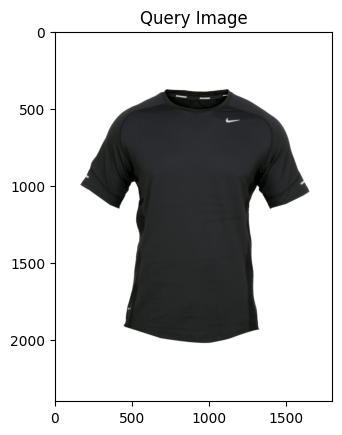

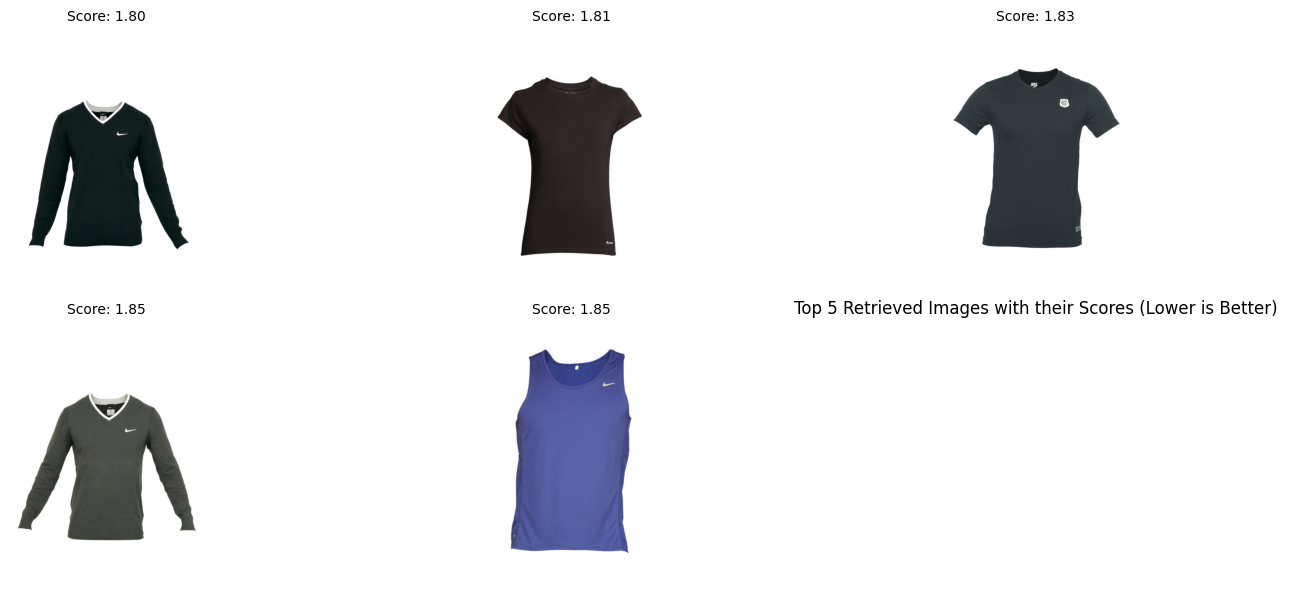

In [ ]:
ind = 8
img = cv2.imread(test_df.iloc[ind]['image_path'])
read_and_plot_img(test_df.iloc[ind]['image_path'])
tree_scores, tree_images = tree.query(img)
plot_top_k_images(tree_scores, tree_images, 5)

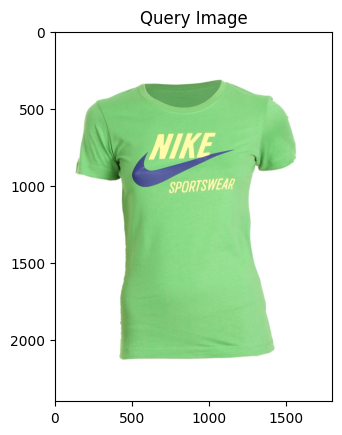

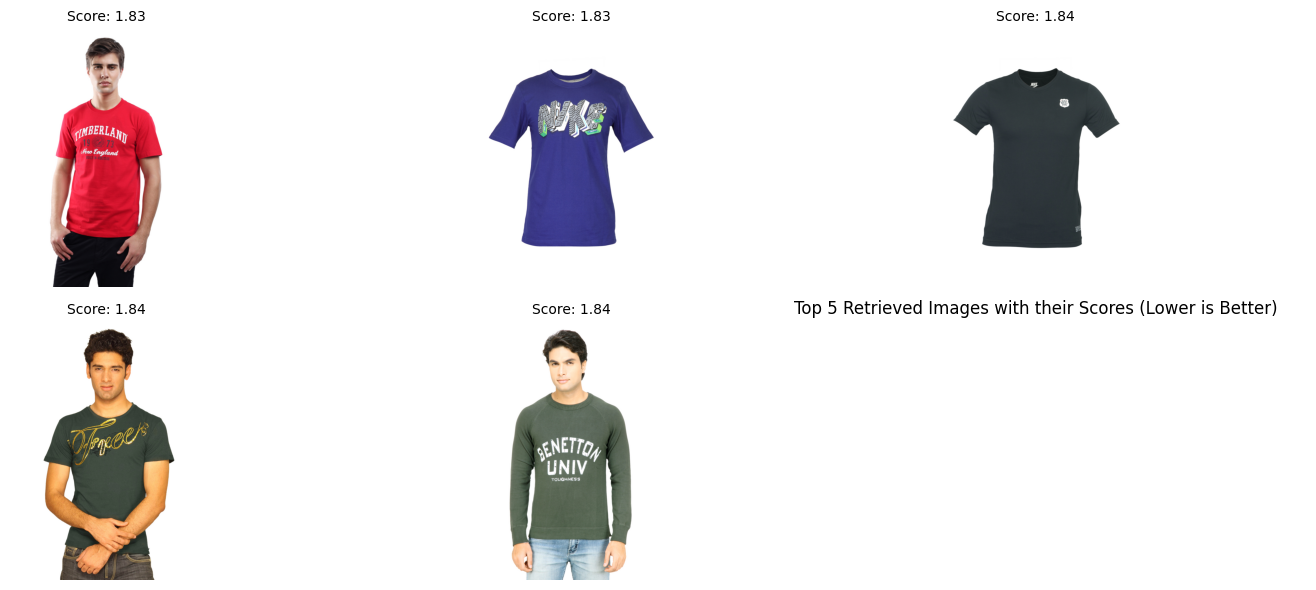

In [13]:
ind = 10
img = cv2.imread(test_df.iloc[ind]['image_path'])
read_and_plot_img(test_df.iloc[ind]['image_path'])
tree_scores, tree_images = tree.query(img)
plot_top_k_images(tree_scores, tree_images, 5)

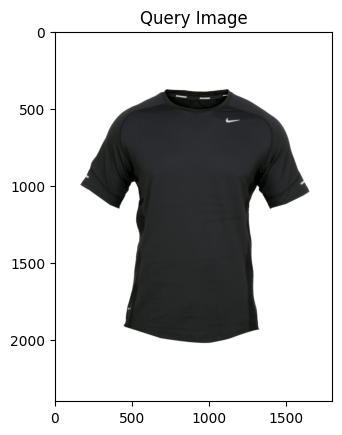

In [16]:
ind = 8
img = cv2.imread(test_df.iloc[ind]['image_path'])
read_and_plot_img(test_df.iloc[ind]['image_path'])

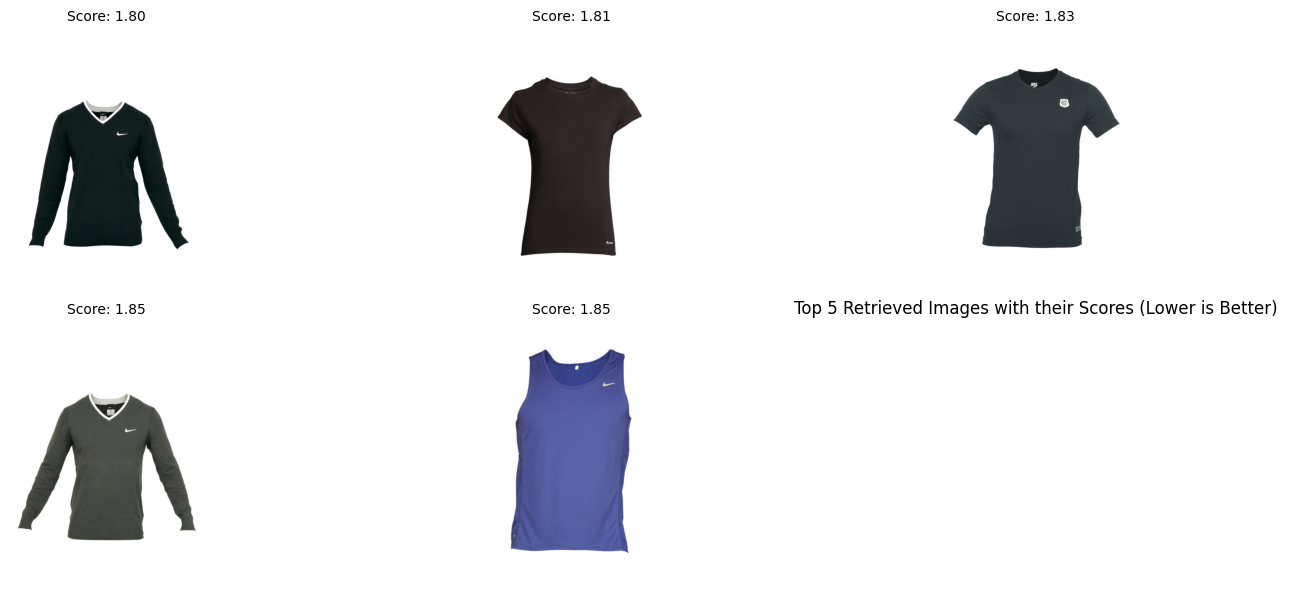

In [19]:
tree_scores, tree_images = tree.query(img)
plot_top_k_images(tree_scores, tree_images, 5)

In [ ]:
with open(os.getcwd() + '\\trees\\tree_superpoint_16_5.pkl', 'rb') as f:
    tree = pickle.load(f)
f.close()
